# ILA Project

In [18]:
import transform
import analysis

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
image_path = r"./Boneyard_IMG_5341.jpg"

## 1. Fast Fourier Transform

In [3]:
fft = transform.FFT(image_path)
fft_vis = analysis.Visualization(fft)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


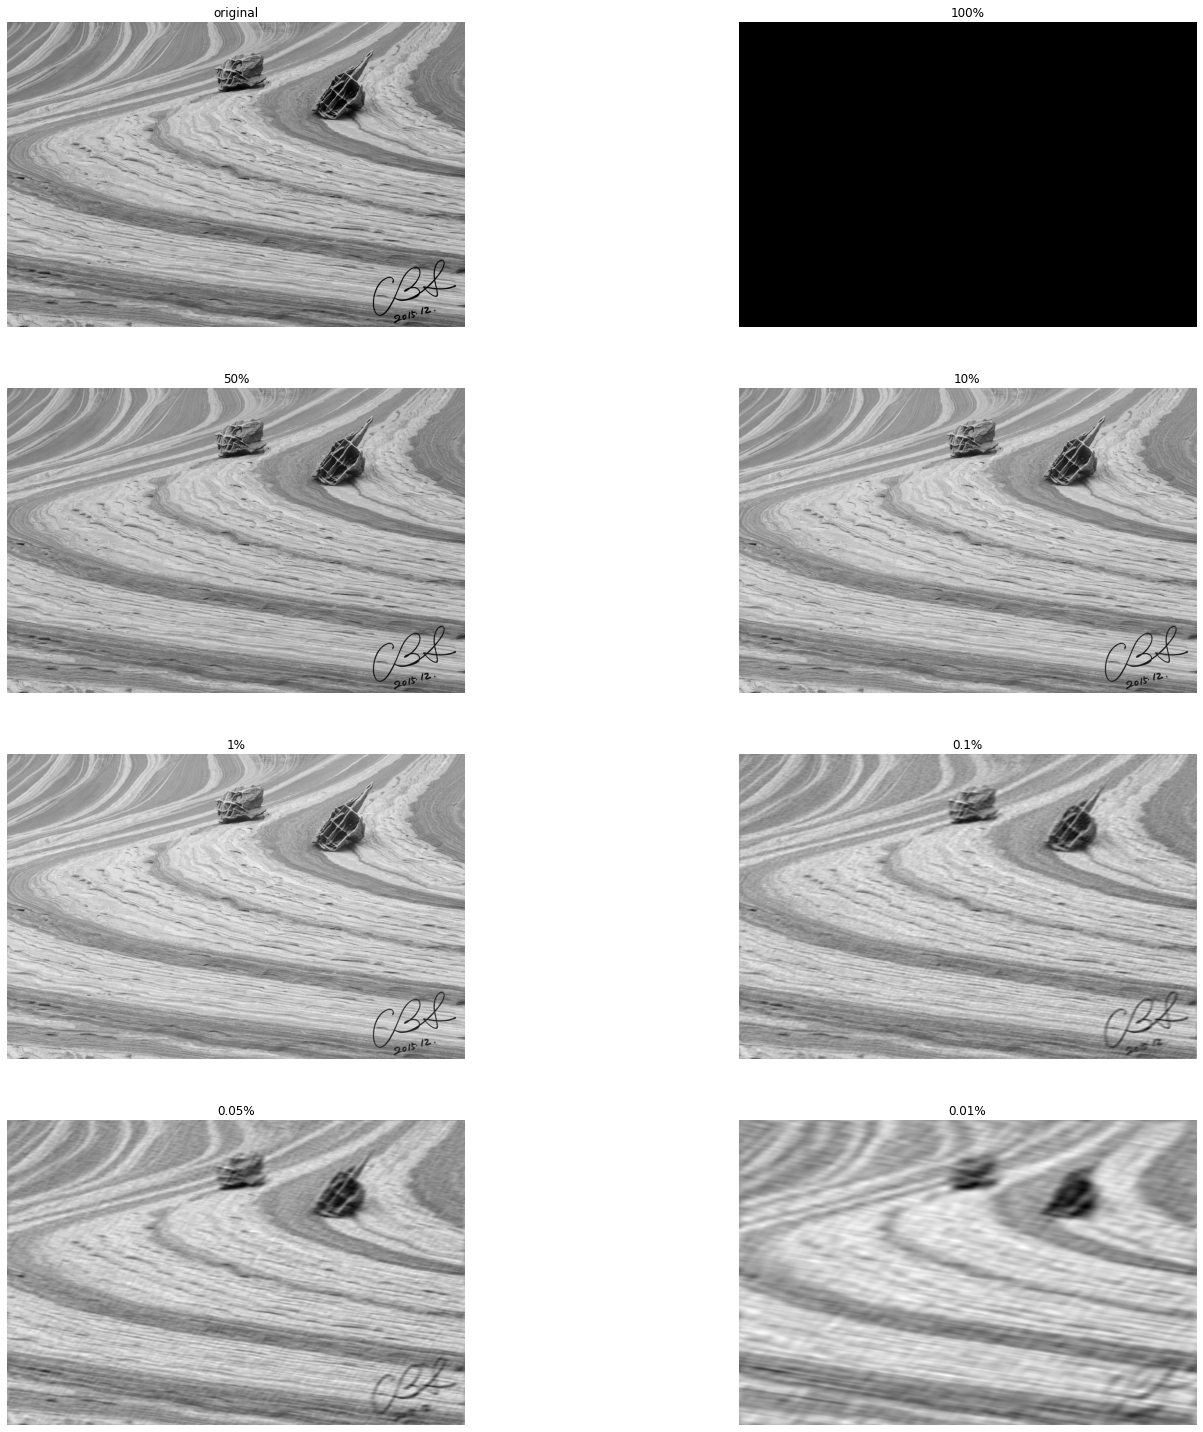

In [4]:
fft_vis.compare_the_whole_by_compression_ratio(grid_width=2)

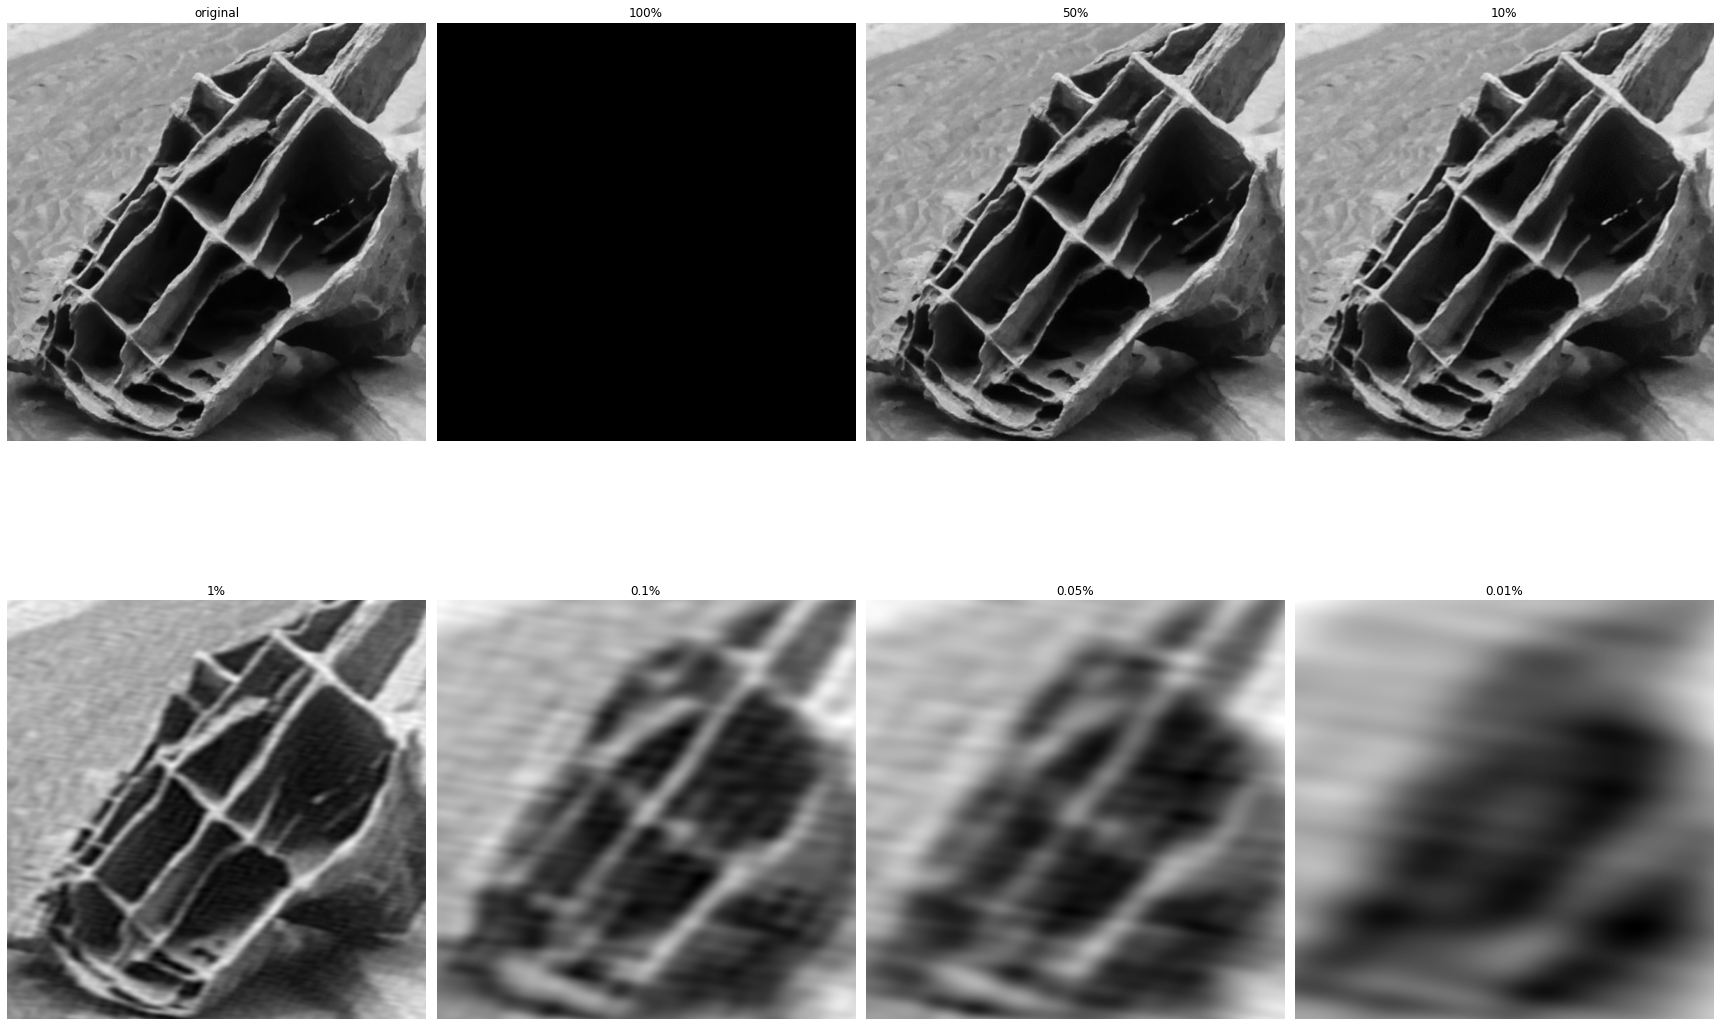

In [5]:
fft_vis.compare_the_waffle_by_compression_ratio(figsize=(24, 15), grid_width=4)

## 2. Haar Wavelet Transform

In [6]:
haar = transform.HaarWT(image_path)
haar_vis = analysis.Visualization(haar)

100%|██████████| 7/7 [02:34<00:00, 22.00s/it]


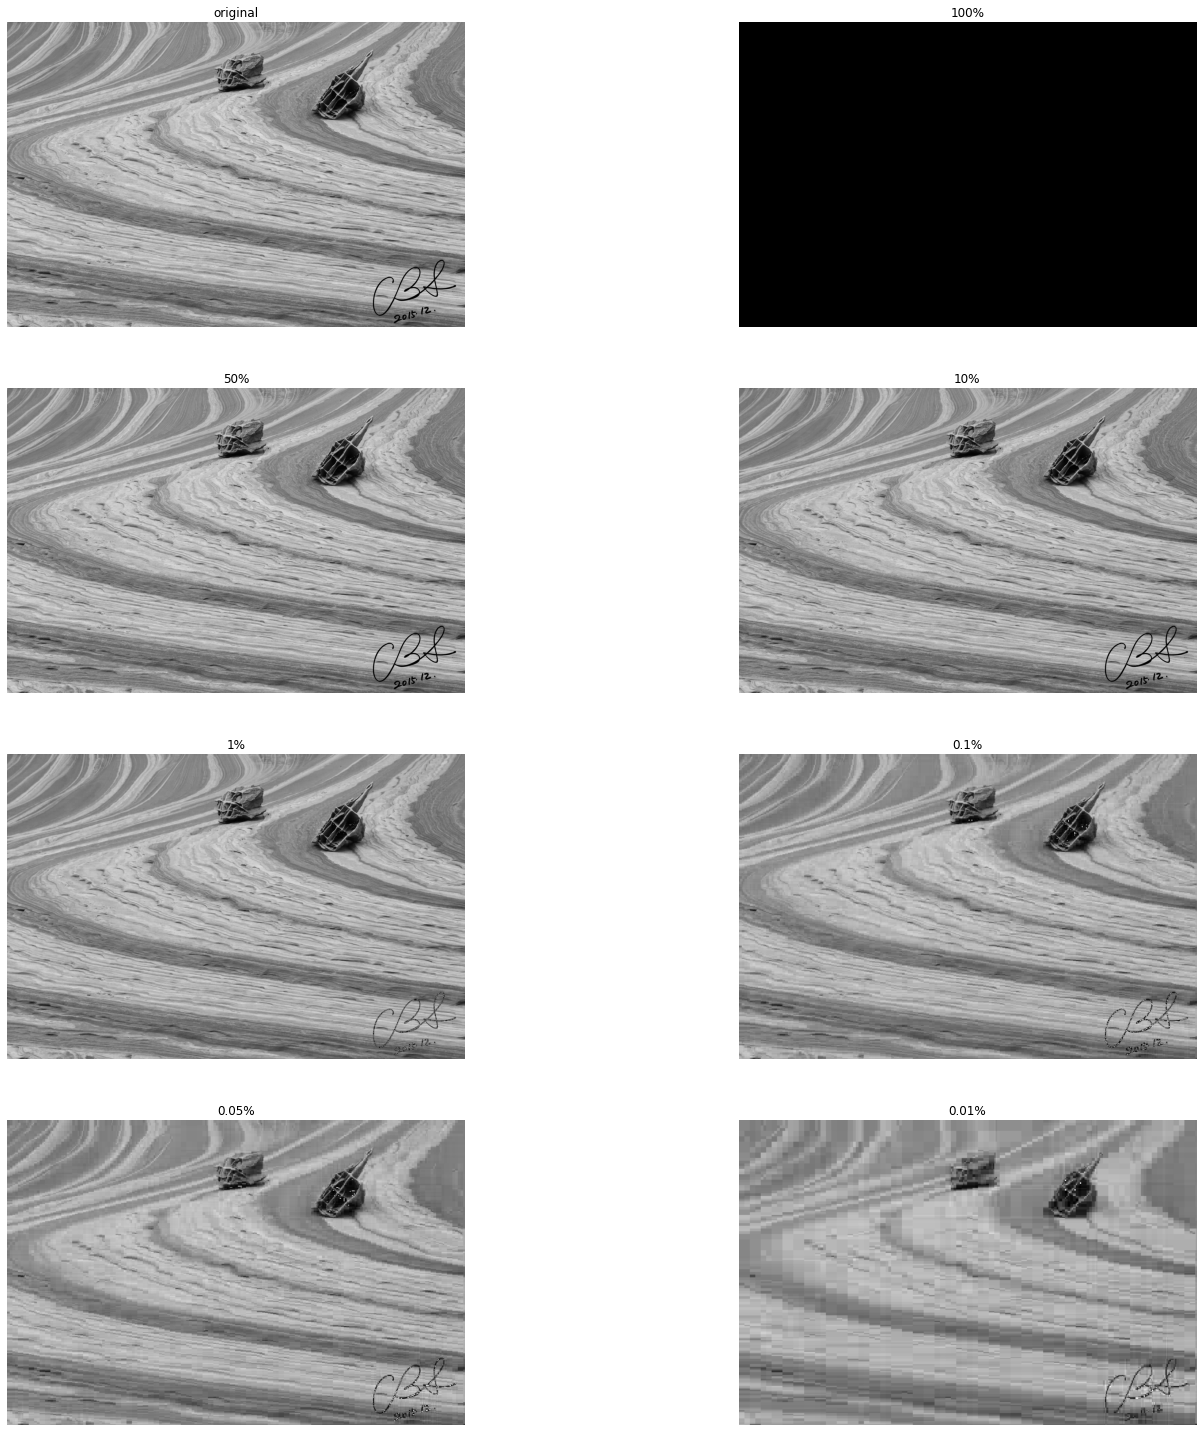

In [7]:
haar_vis.compare_the_whole_by_compression_ratio(grid_width=2)

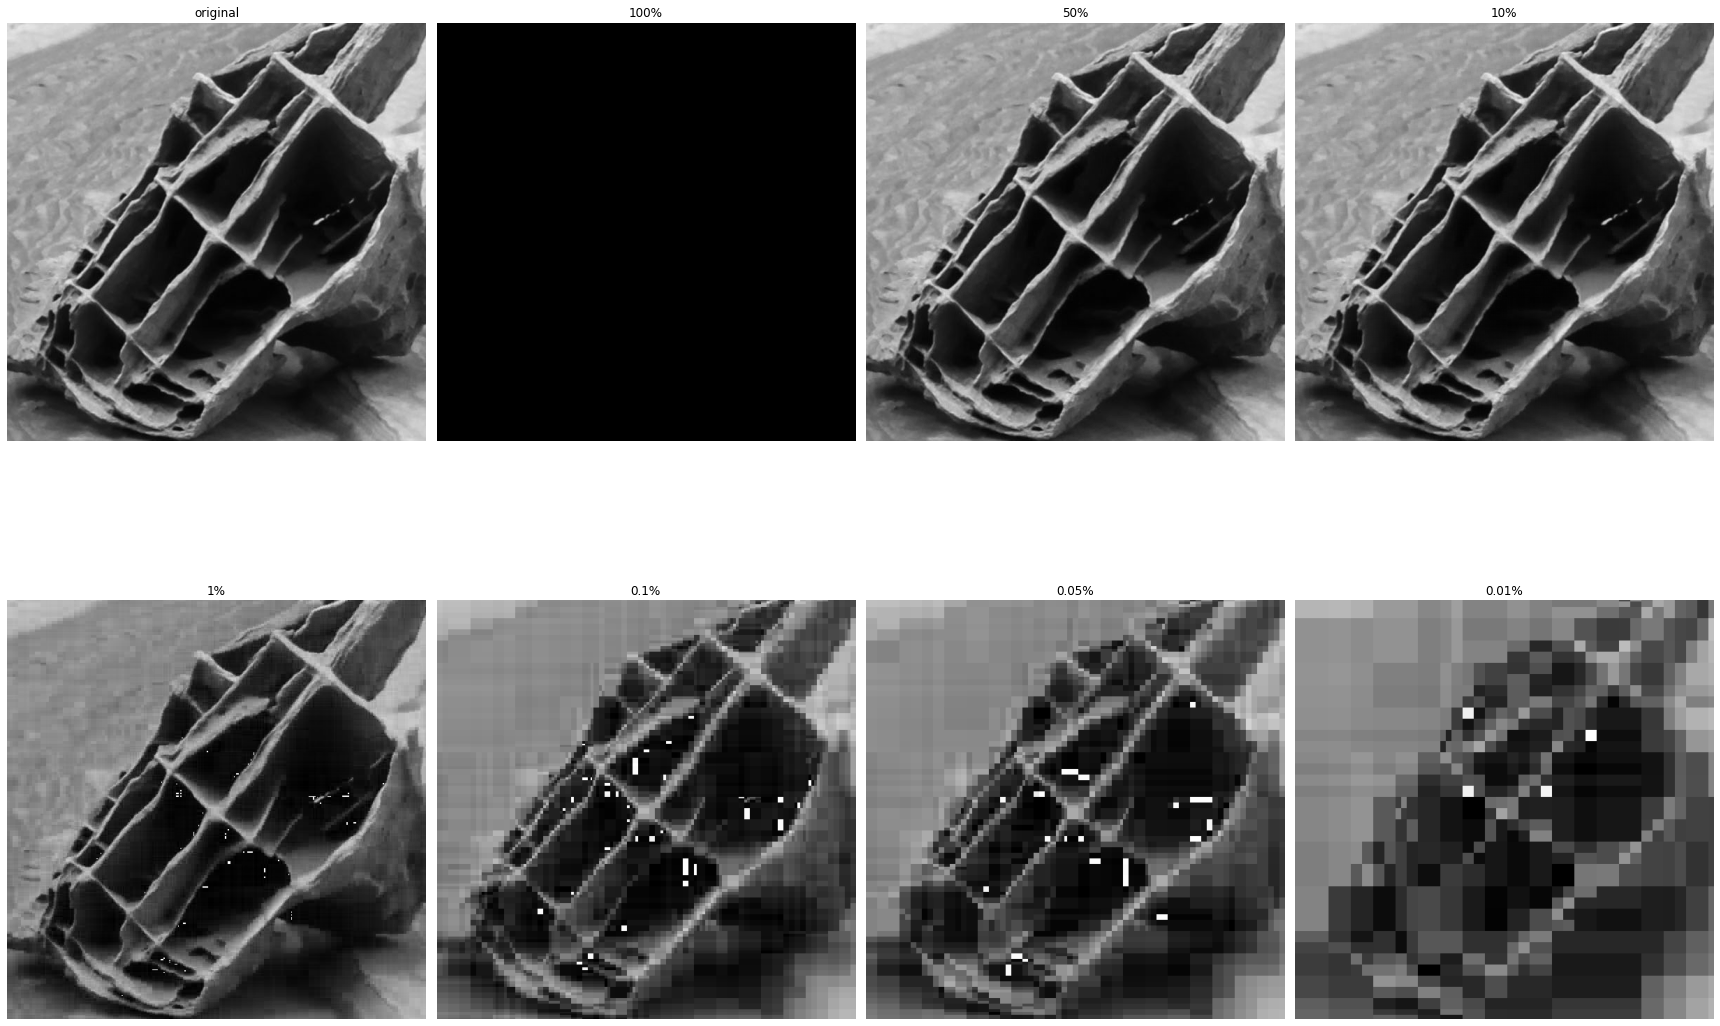

In [8]:
haar_vis.compare_the_waffle_by_compression_ratio(figsize=(24, 15), grid_width=4)

## 3. Continuous Wavelet Transformation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.image import imread

In [5]:
image = imread(image_path)
image = np.mean(image, axis=-1)

CWT는 DWT와 다르게 threshold로 compression을 하지않고, detail부분의 scale을 버리는 식으로 구현하였다.

In [12]:
# set up a range of scales in logarithmic spacing between 1 and 256 (image width / 2 seems to work here)
ss = np.geomspace(1.0,256.0,100)
# calculate the wavelet normalizations
cwt = transform.CWT(image_path)

100%|██████████| 100/100 [09:02<00:00,  5.42s/it]


In [13]:
coeffs, wav_norm = cwt.transformed_matrix, cwt.wave_norm

In [21]:
def calculate_rmse(image1, image2):
    # Normalize pixel values to the range of 0 to 1
    image1 = image1 / 255.0
    image2 = image2 / 255.0

    # Calculate MSE
    mse = np.mean((image1 - image2) ** 2)

    # Calculate RMSE
    rmse = np.sqrt(mse)

    return rmse

  0%|          | 0/100 [00:00<?, ?it/s]/home/jklee/anaconda3/envs/HRL/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
100%|██████████| 100/100 [20:38<00:00, 12.38s/it]


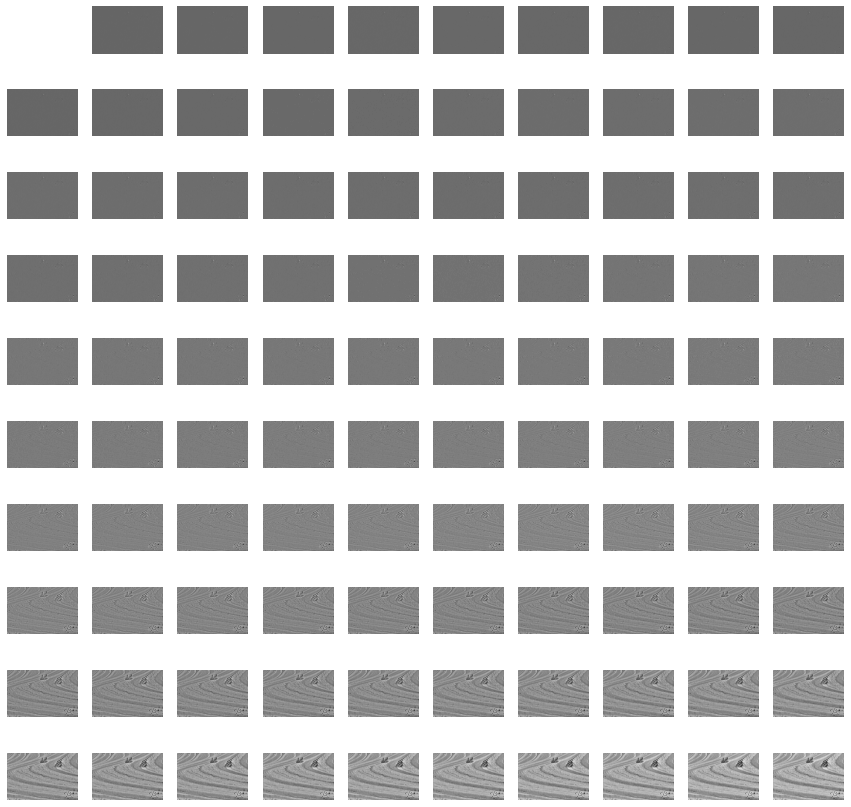

In [22]:
# plot an image showing the combinations of all the scales
errors = []
N = 10
fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(15, 15))
for level in tqdm(range(len(ss))):
    i = level // N
    j = level % N
    plt.sca(axes[i, j])
    plt.axis('off')
    C = 1.0 / (ss[:level] * wav_norm[:level])
    reconstruction = (C * np.real(coeffs[..., :level])).sum(axis=-1)
    reconstruction = 1.0 - (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())
    errors.append(calculate_rmse(reconstruction, image))
    plt.imshow(reconstruction, cmap='gray')
plt.show()

각 scale을 얼마나 활용하는지에 따라 시각적으로 이미지를 확인해본 결과, 90% 이상을 사용할 때 어느정도 원본 이미지가 복원되었다.

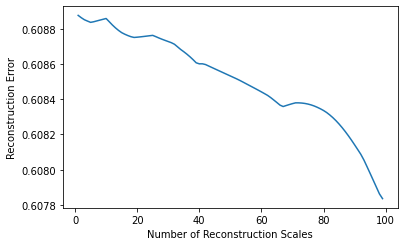

In [23]:
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6/1.618))
plt.plot(errors, label='norm')
plt.xlabel('Number of Reconstruction Scales')
plt.ylabel('Reconstruction Error')
plt.show()

원본 이미지와의 RMSE 또한 당연히 scale을 많이 쓸 수록 줄어드는 경향을 보인다.

In [31]:
chosen_level = 96
C = 1.0 / (ss[:chosen_level] * wav_norm[:chosen_level])
chosen_reconstruction = (C * np.real(coeffs[..., :chosen_level])).sum(axis=-1)
chosen_reconstruction = 1.0 - (chosen_reconstruction - chosen_reconstruction.min()) / (chosen_reconstruction.max() - chosen_reconstruction.min())

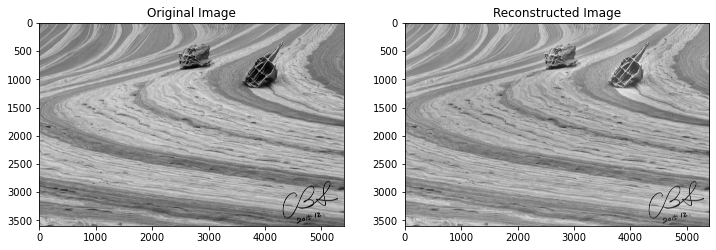

In [33]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(chosen_reconstruction, cmap='gray')
axes[1].set_title('Reconstructed Image')
plt.show()

그 중 임의로 하나의 scale을 정하여 이미지를 복원하였는데, 전반적으로 검은색이 줄어든 것을 확일할 수 있었다. 이는 크게 두 가지 이유로 보인다.
1) CWT 특성상 inverse transform을 할 때, DWT와 다르게 에러가 발생할 수 밖에없음.
2) 임의로 정한 scale의 값들이 해당 이미지를 표현하기에 최적화되지 않았을 수 있음.

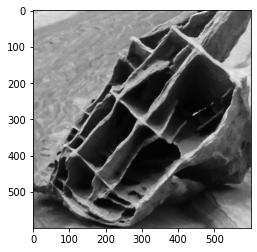

In [38]:
# Original image
plt.imshow(image[550:1150,3600:4200], cmap='gray')
plt.show()

4it [00:53, 13.41s/it]


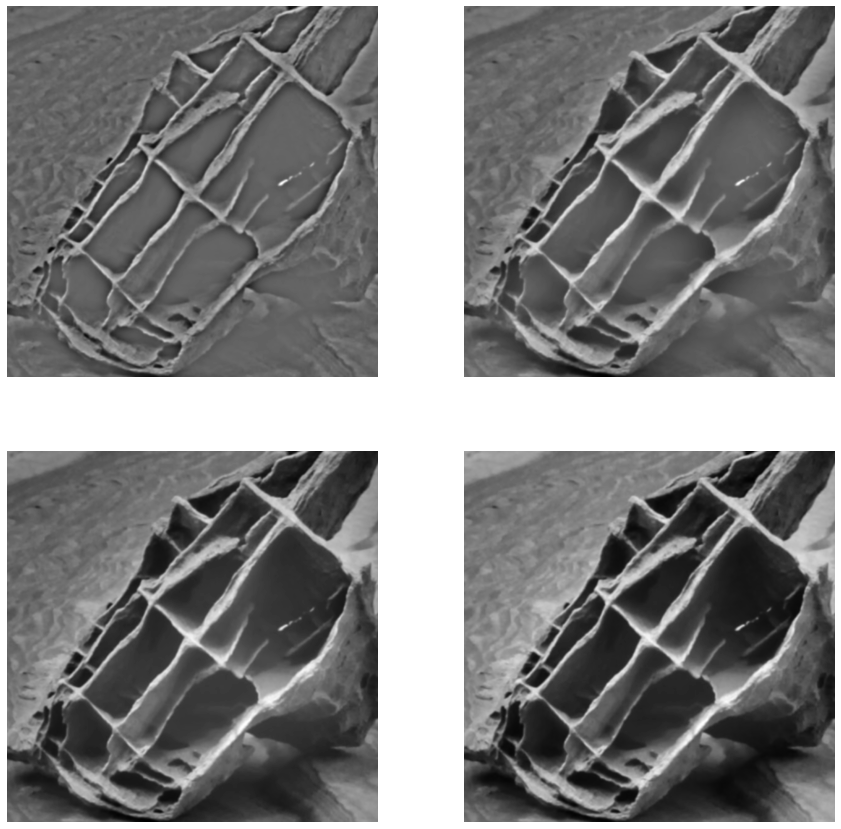

In [27]:
# plot an complicate structure showing the combinations of certain the scales
levels = [40, 60, 80, 90]
N = 2
fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(15, 15))
for idx, level in tqdm(enumerate(levels)):
    i = idx // N
    j = idx % N
    plt.sca(axes[i, j])
    plt.axis('off')
    C = 1.0 / (ss[:level] * wav_norm[:level])
    reconstruction = (C * np.real(coeffs[..., :level])).sum(axis=-1)
    reconstruction = 1.0 - (reconstruction - reconstruction.min()) / (reconstruction.max() - reconstruction.min())
    plt.imshow(reconstruction[550:1150,3600:4200], cmap='gray')
plt.show()

사진에서 가장 복잡해 보이는 구조물을 택해서 자세히 살펴본 결과, DWT와는 다르게 특정 부분에서 이미지가 깨져 흰색으로 보이는 현상이 나타나지 않고, 전반적으로 균질적으로 이미지가 부정확해진다. 이 또한 CWT를 활용하는 특징 중 하나라고 생각된다.

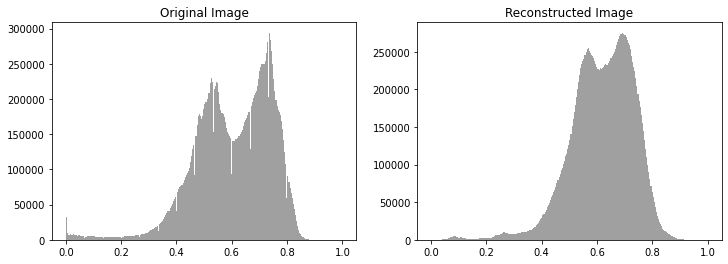

In [34]:
image = (image - image.min()) / (image.max() - image.min())
flattened_image = image.flatten()
flattened_r_image = chosen_reconstruction.flatten()

# Plotting the histogram of original image
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(flattened_image, bins=256, range=[0,1], density=False, color='gray', alpha=0.75)
axes[0].set_title('Original Image')
axes[1].hist(flattened_r_image, bins=256, range=[0,1], density=False, color='gray', alpha=0.75)
axes[1].set_title('Reconstructed Image')
plt.show()

히스토그램으로 만들어진 이미지를 확인해 볼 때, 분포가 좀 더 smooth해지고, 중앙 값에 더 모이는 것을 확인 할 수 있었다. 특히 검은색 부분(0)이 많이 사라진 것을 두드러지게 확인할 수 있었다.